In [40]:
# Installing kaggle to download the dataset.
!pip install kaggle
# Installing wandb for tracking the project.
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00


In [2]:
# We need kaggle credentials which needs to be stored in ~/.kaggle/kaggle.json
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

In [3]:
import os
from getpass import getpass

# Reading in the contents of user's kaggle.json.
kaggle_secret = getpass('Enter the content of your kaggle.json: ')

# Saving into the previously created file.
with open('/root/.kaggle/kaggle.json', "w") as f:
  f.write(kaggle_secret)

Enter the content of your kaggle.json: ··········


In [41]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
# Downloading and unzipping the training dataset.
!kaggle competitions download -c tpu-getting-started
!unzip tpu-getting-started.zip -d data
!rm tpu-getting-started.zip

100% 4.79G/4.79G [02:41<00:00, 37.2MB/s]
100% 4.79G/4.79G [02:41<00:00, 31.8MB/s]
Archive:  tpu-getting-started.zip
  inflating: data/sample_submission.csv  
  inflating: data/tfrecords-jpeg-192x192/test/00-192x192-462.tfrec  
  inflating: data/tfrecords-jpeg-192x192/test/01-192x192-462.tfrec  
  inflating: data/tfrecords-jpeg-192x192/test/02-192x192-462.tfrec  
  inflating: data/tfrecords-jpeg-192x192/test/03-192x192-462.tfrec  
  inflating: data/tfrecords-jpeg-192x192/test/04-192x192-462.tfrec  
  inflating: data/tfrecords-jpeg-192x192/test/05-192x192-462.tfrec  
  inflating: data/tfrecords-jpeg-192x192/test/06-192x192-462.tfrec  
  inflating: data/tfrecords-jpeg-192x192/test/07-192x192-462.tfrec  
  inflating: data/tfrecords-jpeg-192x192/test/08-192x192-462.tfrec  
  inflating: data/tfrecords-jpeg-192x192/test/09-192x192-462.tfrec  
  inflating: data/tfrecords-jpeg-192x192/test/10-192x192-462.tfrec  
  inflating: data/tfrecords-jpeg-192x192/test/11-192x192-462.tfrec  
  inflating: d

In [19]:
import tensorflow as tf
import numpy as np
import re

# Paths to the training, validation and test datasets.
DATASET_PATH = "data"
PATH = DATASET_PATH + "/tfrecords-jpeg-224x224"
TRAINING_FILENAMES = tf.io.gfile.glob(PATH + "/train/*.tfrec")
VALIDATION_FILENAMES = tf.io.gfile.glob(PATH + "/val/*.tfrec")
TEST_FILENAMES = tf.io.gfile.glob(PATH + "/test/*.tfrec")

# Training related constants.
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32
NUM_OF_CLASSES = 104

# Flower classes corresponding to each id (0..103).
CLASSES = [
    "pink primrose",  # 0
    "hard-leaved pocket orchid",  # 1
    "canterbury bells",  # 2
    "sweet pea",  # 3
    "wild geranium",  # 4
    "tiger lily",  # 5
    "moon orchid",  # 6
    "bird of paradise",  # 7
    "monkshood",  # 8
    "globe thistle",  # 9
    "snapdragon",  # 10
    "colt's foot",  # 11
    "king protea",  # 12
    "spear thistle",  # 13
    "yellow iris",  # 14
    "globe-flower",  # 15
    "purple coneflower",  # 16
    "peruvian lily",  # 17
    "balloon flower",  # 18
    "giant white arum lily",  # 19
    "fire lily",  # 20
    "pincushion flower",  # 21
    "fritillary",  # 22
    "red ginger",  # 23
    "grape hyacinth",  # 24
    "corn poppy",  # 25
    "prince of wales feathers",  # 26
    "stemless gentian",  # 27
    "artichoke",  # 28
    "sweet william",  # 29
    "carnation",  # 30
    "garden phlox",  # 31
    "love in the mist",  # 32
    "cosmos",  # 33
    "alpine sea holly",  # 34
    "ruby-lipped cattleya",  # 35
    "cape flower",  # 36
    "great masterwort",  # 37
    "siam tulip",  # 38
    "lenten rose",  # 39
    "barberton daisy",  # 40
    "daffodil",  # 41
    "sword lily",  # 42
    "poinsettia",  # 43
    "bolero deep blue",  # 44
    "wallflower",  # 45
    "marigold",  # 46
    "buttercup",  # 47
    "daisy",  # 48
    "common dandelion",  # 49
    "petunia",  # 50
    "wild pansy",  # 51
    "primula",  # 52
    "sunflower",  # 53
    "lilac hibiscus",  # 54
    "bishop of llandaff",  # 55
    "gaura",  # 56
    "geranium",  # 57
    "orange dahlia",  # 58
    "pink-yellow dahlia",  # 59
    "cautleya spicata",  # 60
    "japanese anemone",  # 61
    "black-eyed susan",  # 62
    "silverbush",  # 63
    "californian poppy",  # 64
    "osteospermum",  # 65
    "spring crocus",  # 66
    "iris",  # 67
    "windflower",  # 68
    "tree poppy",  # 69
    "gazania",  # 70
    "azalea",  # 71
    "water lily",  # 72
    "rose",  # 73
    "thorn apple",  # 74
    "morning glory",  # 75
    "passion flower",  # 76
    "lotus",  # 77
    "toad lily",  # 78
    "anthurium",  # 79
    "frangipani",  # 80
    "clematis",  # 81
    "hibiscus",  # 82
    "columbine",  # 83
    "desert-rose",  # 84
    "tree mallow",  # 85
    "magnolia",  # 86
    "cyclamen ",  # 87
    "watercress",  # 88
    "canna lily",  # 89
    "hippeastrum ",  # 90
    "bee balm",  # 91
    "pink quill",  # 92
    "foxglove",  # 93
    "bougainvillea",  # 94
    "camellia",  # 95
    "mallow",  # 96
    "mexican petunia",  # 97
    "bromelia",  # 98
    "blanket flower",  # 99
    "trumpet creeper",  # 100
    "blackberry lily",  # 101
    "common tulip",  # 102
    "wild rose",  # 103
]

In [6]:
# This function converts the raw image data to a [IMAGE_SIZE, 3] shaped array
# containing the normalized color intensity values for all channels.
def decode_image(image_data):
  # Extracting the image from the dataset.
  image = tf.image.decode_jpeg(image_data, channels=3)
  # Normalizing the color intensity values.
  image = (
      tf.cast(image, tf.float32) / 255.0
  )
  # Reshaping for 3 channels.
  image = tf.reshape(image, [*IMAGE_SIZE, 3])
  return image


# This function takes a raw labelled tfrecord and converts it to decoded image data
# and one hot encoded label.
def read_labelled_tfrecord(example):
  LABELLED_TFREC_FORMAT = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "class": tf.io.FixedLenFeature([], tf.int64),
  }
  # Converting the raw data to a python dictionary with LABELLED_TFREC_FORMAT.
  example = tf.io.parse_single_example(example, LABELLED_TFREC_FORMAT)
  # Decoding the image.
  image = decode_image(example["image"])
  # One-hot encode the label of the image.
  label = tf.cast(example["class"], tf.int32)
  one_hot = tf.one_hot(label, NUM_OF_CLASSES)
  return image, one_hot


# This function takes a raw unlabelled tfrecord and converts it to decoded image data
# and the id of the test image.
def read_unlabelled_tfrecord(example):
  UNLABELLED_TFREC_FORMAT = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "id": tf.io.FixedLenFeature([], tf.string),
  }
  # Converting raw data to a python dictionary with UNLABELLED_TFREC_FORMAT.
  example = tf.io.parse_single_example(example, UNLABELLED_TFREC_FORMAT)
  # Decoding the image.
  image = decode_image(example["image"])
  id_num = example["id"]
  return image, id_num


# This function takes several filenames (tfrecords) and creates a tensorflow
# dataset from them.
def load_dataset(filenames, labelled=True, ordered=False):
  # The order of the images doesn't matter so we are turning on ignore_order
  # this results in faster loading times.
  ignore_order = tf.data.Options()
  if not ordered:
    ignore_order.experimental_deterministic = False

  # Creating the dataset. We are using parallel read option because obviously
  # it results in faster loading times.
  dataset = tf.data.TFRecordDataset(
    filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE
  )
  dataset = dataset.with_options(ignore_order)
  # The final element of the pipeline is taking the raw tfrecord
  # and converting it to labelled on unlabelled input data with the upper functions.
  dataset = dataset.map(
    read_labelled_tfrecord if labelled else read_unlabelled_tfrecord,
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
  )
  return dataset

In [32]:
# This function creates the training dataset.
# repeat will be used, this will make sure that after reaching the end record
# we go back to the first.
# BATCH_SIZE will be used.
# We will prefetch 1 batch for accellerating the reading process.
def get_training_dataset():
  dataset = load_dataset(TRAINING_FILENAMES, labelled=True)
  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(1)
  return dataset

# This function creates the validation dataset.
# BATCH_SIZE will be used.
# We will prefetch 1 batch for accellerating the reading process.
def get_validation_dataset(ordered=False):
  dataset = load_dataset(VALIDATION_FILENAMES, labelled=True, ordered=ordered)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(1)
  return dataset


# This function creates the test dataset.
# BATCH_SIZE will be used.
# We will prefetch 1 batch for accellerating the reading process.
def get_test_dataset(ordered=False):
  dataset = load_dataset(TEST_FILENAMES, labelled=False, ordered=ordered)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(1)
  return dataset


# This function counts the number of tfrecords in a dataset.
def count_data_items(filenames):
  n = [
    int(re.compile(r"-(\d*)\.").search(filename).group(1))
    for filename in filenames
  ]
  return np.sum(n)

In [33]:
# This will be used to calculate the number of batches needed to go through
# all the dataset in an epoch.
num_train_images = count_data_items(TRAINING_FILENAMES)
num_validation_images = count_data_items(VALIDATION_FILENAMES)

# Getting the train, validation and test datasets.
train_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()
test_dataset = get_test_dataset()

In [9]:
# For hyperparameter-optimization keras-tuner will be used.
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.7 MB/s eta 0:00:00


In [16]:
from tensorflow.keras import datasets, layers, models, callbacks, applications, optimizers
import keras_tuner as kt

def build_model(hp):
  # Using Transfer Learning technique for this project.
  # InceptionV3 pretrained model will be used.
  pre_trained_model = applications.InceptionV3(input_shape=(*IMAGE_SIZE, 3), include_top=False, weights='imagenet')
  # Freezing the weights of the model.
  for layer in pre_trained_model.layers:
    layer.trainable = False

  # Adding our own model on top of InceptionV3.
  x = pre_trained_model.output
  # Using pooling to decrease dimension.
  x = layers.GlobalAveragePooling2D()(x)
  # Putting one hidden layer with units.
  x = layers.Dense(hp.Choice('units', [256, 512]), activation='relu')(x)
  # The output will be a probability distribution of classes.
  x = layers.Dense(NUM_OF_CLASSES, activation='softmax')(x)

  # Creating and compiling the final model from the pretrained model and our own model.
  model = models.Model(pre_trained_model.input, x)
  optimizer = optimizers.Adam(learning_rate=0.001)
  model.compile(
      optimizer=optimizer,
      loss='categorical_crossentropy',
      metrics=['acc']
  )
  return model

# Using keras-tuner for hyperparameter-optimization.
tuner = kt.Hyperband(
    build_model,
    objective='val_acc',
    max_epochs=5,
    factor=3,
    directory='best_model',
    project_name='FlowerClassificationModel',
    overwrite=True
)

# Using EarlyStopping to prevent overfitting.
es = callbacks.EarlyStopping(monitor='val_acc', patience=5, verbose=1, mode='max')

# Searching with Hyperband in the hyperparameter-space.
tuner.search(train_dataset,
    validation_data=validation_dataset,
    epochs=25,
    steps_per_epoch=num_train_images / BATCH_SIZE,
    callbacks=[es])

Trial 2 Complete [00h 01m 31s]
val_acc: 0.6608297228813171

Best val_acc So Far: 0.6737607717514038
Total elapsed time: 00h 04m 02s


In [51]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

wandb.init(project = 'flower-classification')

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data for 10 epochs
model = tuner.hypermodel.build(best_hps)

# Saving the best model so far.
cp = callbacks.ModelCheckpoint(filepath='model', monitor='val_acc', mode='max')

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    steps_per_epoch=num_train_images / BATCH_SIZE,
    callbacks=[es, cp, WandbMetricsLogger(), WandbModelCheckpoint('model')])

Epoch 1/10
399/398 [==============================] - ETA: 0s - loss: 2.1714 - acc: 0.4871

wandb: Adding directory to artifact (./model)... Done. 0.3s


398/398 [==============================] - 120s 276ms/step - loss: 2.1714 - acc: 0.4871 - val_loss: 1.5157 - val_acc: 0.6067
Epoch 2/10
399/398 [==============================] - ETA: 0s - loss: 1.1598 - acc: 0.6863

wandb: Adding directory to artifact (./model)... Done. 0.4s


398/398 [==============================] - 100s 252ms/step - loss: 1.1598 - acc: 0.6863 - val_loss: 1.2406 - val_acc: 0.6748
Epoch 3/10
399/398 [==============================] - ETA: 0s - loss: 0.8340 - acc: 0.7704

wandb: Adding directory to artifact (./model)... Done. 0.3s


398/398 [==============================] - 110s 276ms/step - loss: 0.8340 - acc: 0.7704 - val_loss: 1.1900 - val_acc: 0.6883
Epoch 4/10
399/398 [==============================] - ETA: 0s - loss: 0.6225 - acc: 0.8289

wandb: Adding directory to artifact (./model)... Done. 0.3s


398/398 [==============================] - 98s 247ms/step - loss: 0.6225 - acc: 0.8289 - val_loss: 1.2112 - val_acc: 0.6848
Epoch 5/10
399/398 [==============================] - ETA: 0s - loss: 0.4770 - acc: 0.8720

wandb: Adding directory to artifact (./model)... Done. 0.3s


398/398 [==============================] - 107s 268ms/step - loss: 0.4770 - acc: 0.8720 - val_loss: 1.2693 - val_acc: 0.6805
Epoch 6/10
399/398 [==============================] - ETA: 0s - loss: 0.3754 - acc: 0.8999

wandb: Adding directory to artifact (./model)... Done. 0.4s


398/398 [==============================] - 101s 253ms/step - loss: 0.3754 - acc: 0.8999 - val_loss: 1.3157 - val_acc: 0.6827
Epoch 7/10
399/398 [==============================] - ETA: 0s - loss: 0.3041 - acc: 0.9191

wandb: Adding directory to artifact (./model)... Done. 0.4s


398/398 [==============================] - 99s 249ms/step - loss: 0.3041 - acc: 0.9191 - val_loss: 1.3374 - val_acc: 0.6829
Epoch 8/10
399/398 [==============================] - ETA: 0s - loss: 0.2543 - acc: 0.9313

wandb: Adding directory to artifact (./model)... Done. 0.3s


398/398 [==============================] - 104s 260ms/step - loss: 0.2543 - acc: 0.9313 - val_loss: 1.5150 - val_acc: 0.6700
Epoch 8: early stopping


In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

# This function displays the training and validation curves from the history data.
def display_training_curves(training, validation, title, subplot):
  if subplot % 10 == 1:
    plt.subplots(figsize=(10, 10), facecolor="#F0F0F0")
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor("#F8F8F8")
  ax.plot(training)
  ax.plot(validation)
  ax.set_title("model " + title)
  ax.set_ylabel(title)
  ax.set_xlabel("epoch")
  ax.legend(["train", "valid."])

# This function displays the confusion matrix.
def display_confusion_matrix(cmat, score, precision, recall):
  plt.figure(figsize=(15, 15))
  ax = plt.gca()
  ax.matshow(cmat, cmap="Reds")
  ax.set_xticks(range(len(CLASSES)))
  ax.set_xticklabels(CLASSES, fontdict={"fontsize": 7})
  plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
  ax.set_yticks(range(len(CLASSES)))
  ax.set_yticklabels(CLASSES, fontdict={"fontsize": 7})
  plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
  title = ""
  if score is not None:
    title += "f1 = {:.3f} ".format(score)
  if precision is not None:
    title += "\nprecision = {:.3f} ".format(precision)
  if recall is not None:
    title += "\nrecall = {:.3f} ".format(recall)
  if len(title) > 0:
    ax.text(
      101,
      1,
      title,
      fontdict={
        "fontsize": 18,
        "horizontalalignment": "right",
        "verticalalignment": "top",
        "color": "#804040",
      },
    )
  plt.show()

# This function generates a confusion matrix with the model from the validation_dataset.
def generate_confusion_matrix(model, validation_dataset, number_validation_images):
    images_ds = validation_dataset.map(lambda image, label: image)
    labels_ds = validation_dataset.map(lambda image, label: label).unbatch()

    correct_labels = next(iter(labels_ds.batch(number_validation_images))).numpy()
    correct_labels = np.argmax(correct_labels, axis=-1)
    probabilities = model.predict(images_ds)
    predictions = np.argmax(probabilities, axis=-1)

    labels = range(len(CLASSES))
    cmat = confusion_matrix(correct_labels, predictions, labels=labels)
    cmat = (cmat.T / cmat.sum(axis=1)).T  # normalize

    f1 = f1_score(correct_labels, predictions, labels=labels, average="macro")
    precision = precision_score(
      correct_labels, predictions, labels=labels, average="macro"
    )
    recall = recall_score(correct_labels, predictions, labels=labels, average="macro")

    display_confusion_matrix(cmat, f1, precision, recall)

<ipython-input-52-3a0208ac4c0e>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


116/116 [==============================] - 10s 70ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


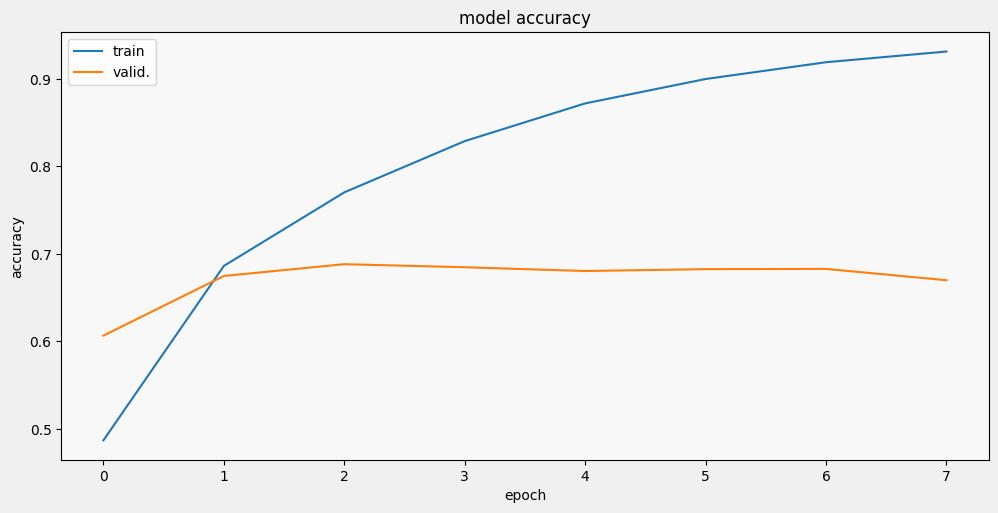

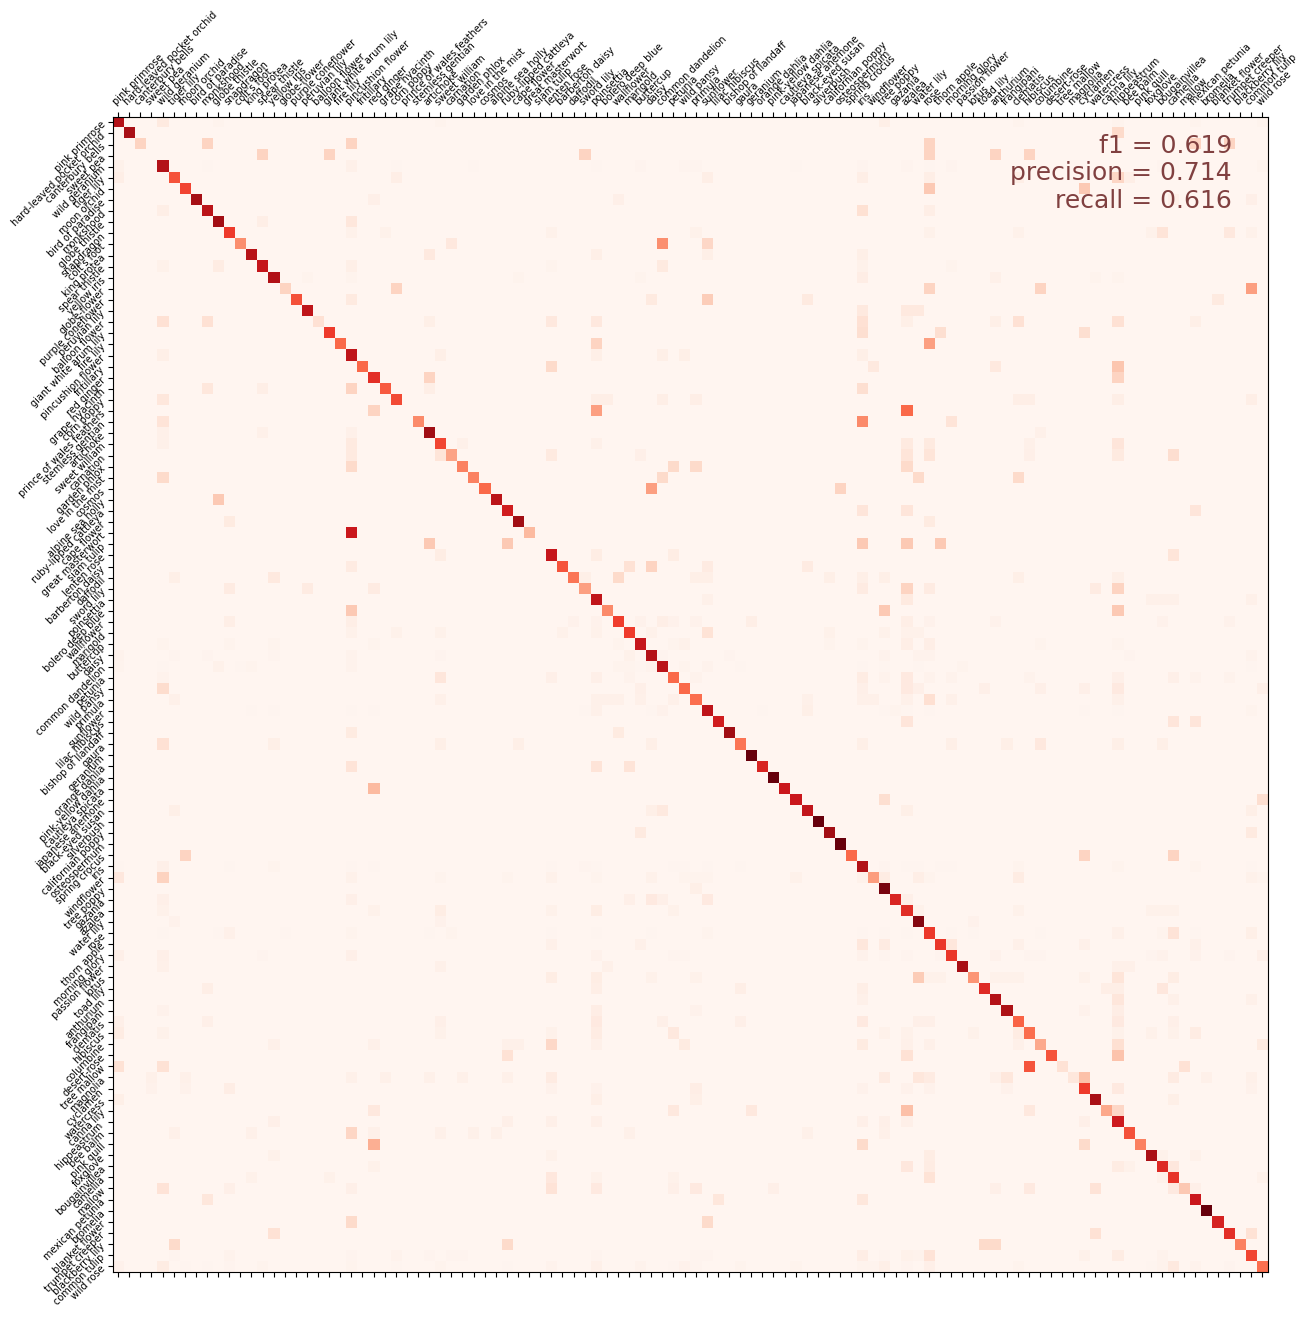

In [53]:
display_training_curves(
    history.history["acc"],
    history.history["val_acc"],
    "accuracy",
    211,
)
generate_confusion_matrix(model, validation_dataset, num_validation_images)